In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install -q supervision
!pip install -q roboflow
!pip install -q salesforce-lavis

Reason for being yanked: deprecated, use 4.8.0.76
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
salesforce-lavis 1.0.2 requires opencv-python-headless==4.5.5.64, but you have opencv-python-headless 4.8.0.74 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.32 requires opencv-python-headless==4.8.0.74, but you have opencv-python-headless 4.5.5.64 which is incompatible.


## Download dataset

In [ ]:
!pip install ultralytics


import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("roboflow-jvuqo").project("fashion-assistant-segmentation")
dataset = project.version(5).download("yolov8")

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.35, to fix: `pip install ultralytics==8.0.196`


In [ ]:
#blip
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_DIR = f"{dataset.location}/train/images"
SAMPLE_SIZE = 25

In [ ]:
from lavis.models import load_model_and_preprocess
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=DEVICE)

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.35G/1.35G [00:18<00:00, 79.4MB/s]


In [ ]:
import cv2
import PIL
import numpy as np
import supervision as sv
from typing import Tuple
from PIL import Image


def load_image(image_path: str) -> Tuple[PIL.Image.Image, np.ndarray]:
    image_pil = Image.open(image_path).convert("RGB")
    image_numpy = np.asarray(image_pil)
    image_numpy = cv2.cvtColor(image_numpy, cv2.COLOR_RGB2BGR)
    return image_pil, image_numpy

In [ ]:
import random

image_paths = sv.list_files_with_extensions(directory=IMAGE_DIR, extensions=["jpg", "jpeg", "png"])
image_paths = random.sample(image_paths, SAMPLE_SIZE)

  0%|          | 0/25 [00:00<?, ?it/s]

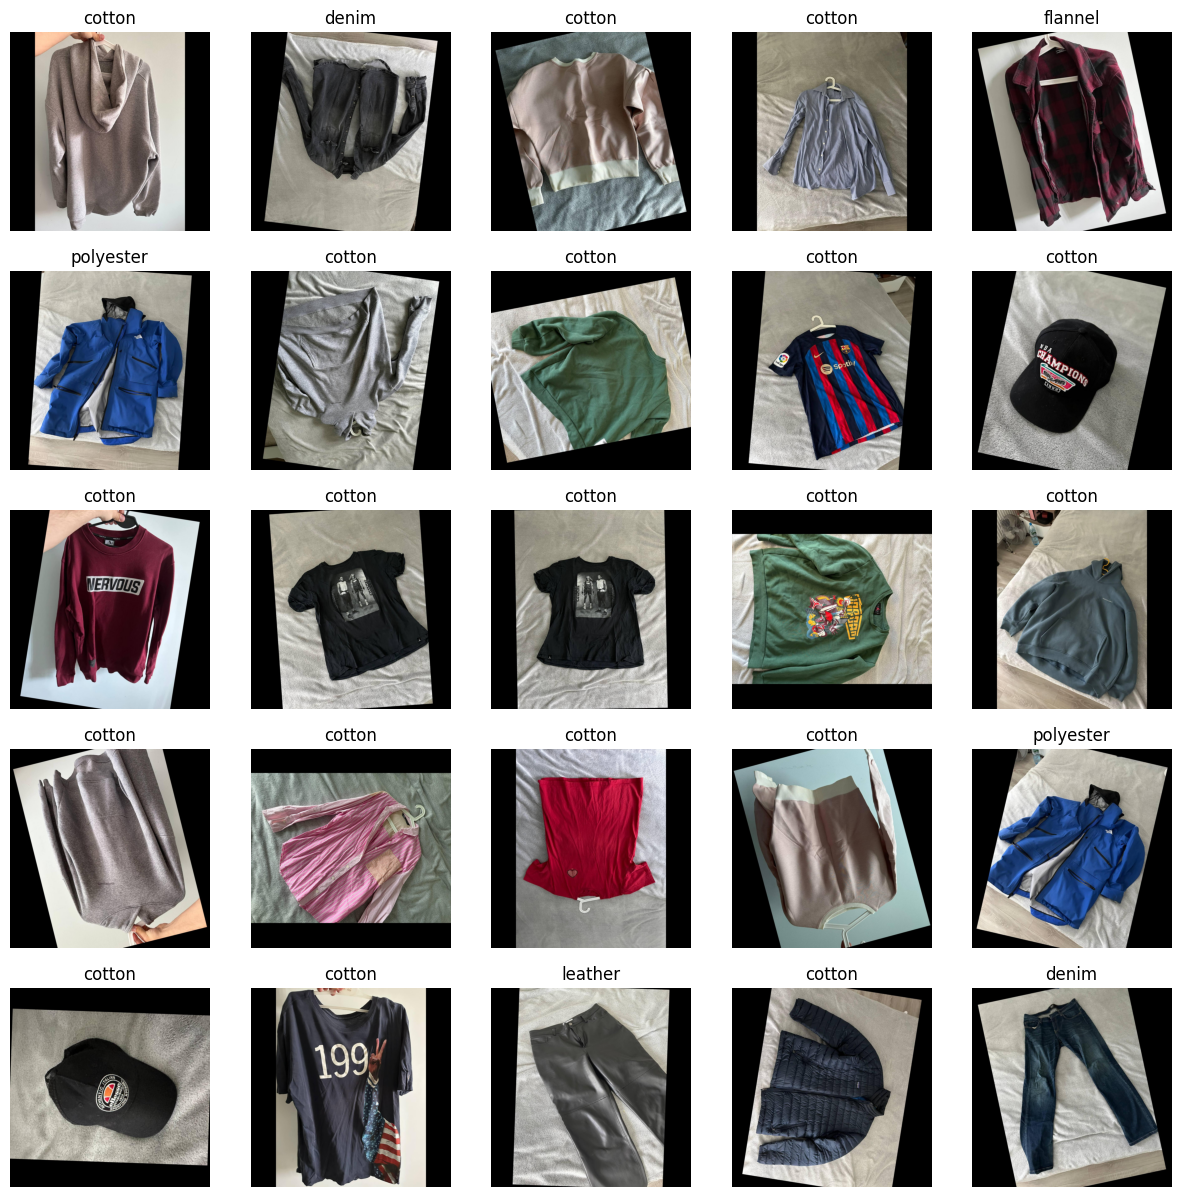

In [ ]:
from tqdm.notebook import tqdm

PROMPT = "What material is the clothing made of?"

prompt_processed = txt_processors["eval"](PROMPT)

images_numpy = []
predictions = []

for image_path in tqdm(image_paths):
    image_pil, image_numpy = load_image(image_path=str(image_path))
    image_processed = vis_processors["eval"](image_pil).unsqueeze(0).to(DEVICE)
    prediction = model.predict_answers(samples={"image": image_processed, "text_input": prompt_processed}, inference_method="generate")[0]
    images_numpy.append(image_numpy)
    predictions.append(prediction)

sv.plot_images_grid(images_numpy, grid_size=(5, 5), titles=predictions, size=(15, 15))

In [ ]:
from tqdm.notebook import tqdm

PROMPT = "Is this clothing appropriate for winter weather?"

prompt_processed = txt_processors["eval"](PROMPT)

images_numpy = []
predictions = []

for image_path in tqdm(image_paths):
    image_pil, image_numpy = load_image(image_path=str(image_path))
    image_processed = vis_processors["eval"](image_pil).unsqueeze(0).to(DEVICE)
    prediction = model.predict_answers(samples={"image": image_processed, "text_input": prompt_processed}, inference_method="generate")[0]
    images_numpy.append(image_numpy)
    predictions.append(prediction)

sv.plot_images_grid(images_numpy, grid_size=(5, 5), titles=predictions, size=(15, 15))

NameError: name 'txt_processors' is not defined

## CLIP Demo

In [ ]:
STYLES = [
    'Casual',
    'Professional',
    'Athletic',
    'Streetwear',
    'Boho',
    'Vintage',
    'Punk',
    'Goth',
    'Minimalist',
    'High Fashion',
    'Country',
    'Tropical',
    'Formal'
]

  0%|          | 0/25 [00:00<?, ?it/s]

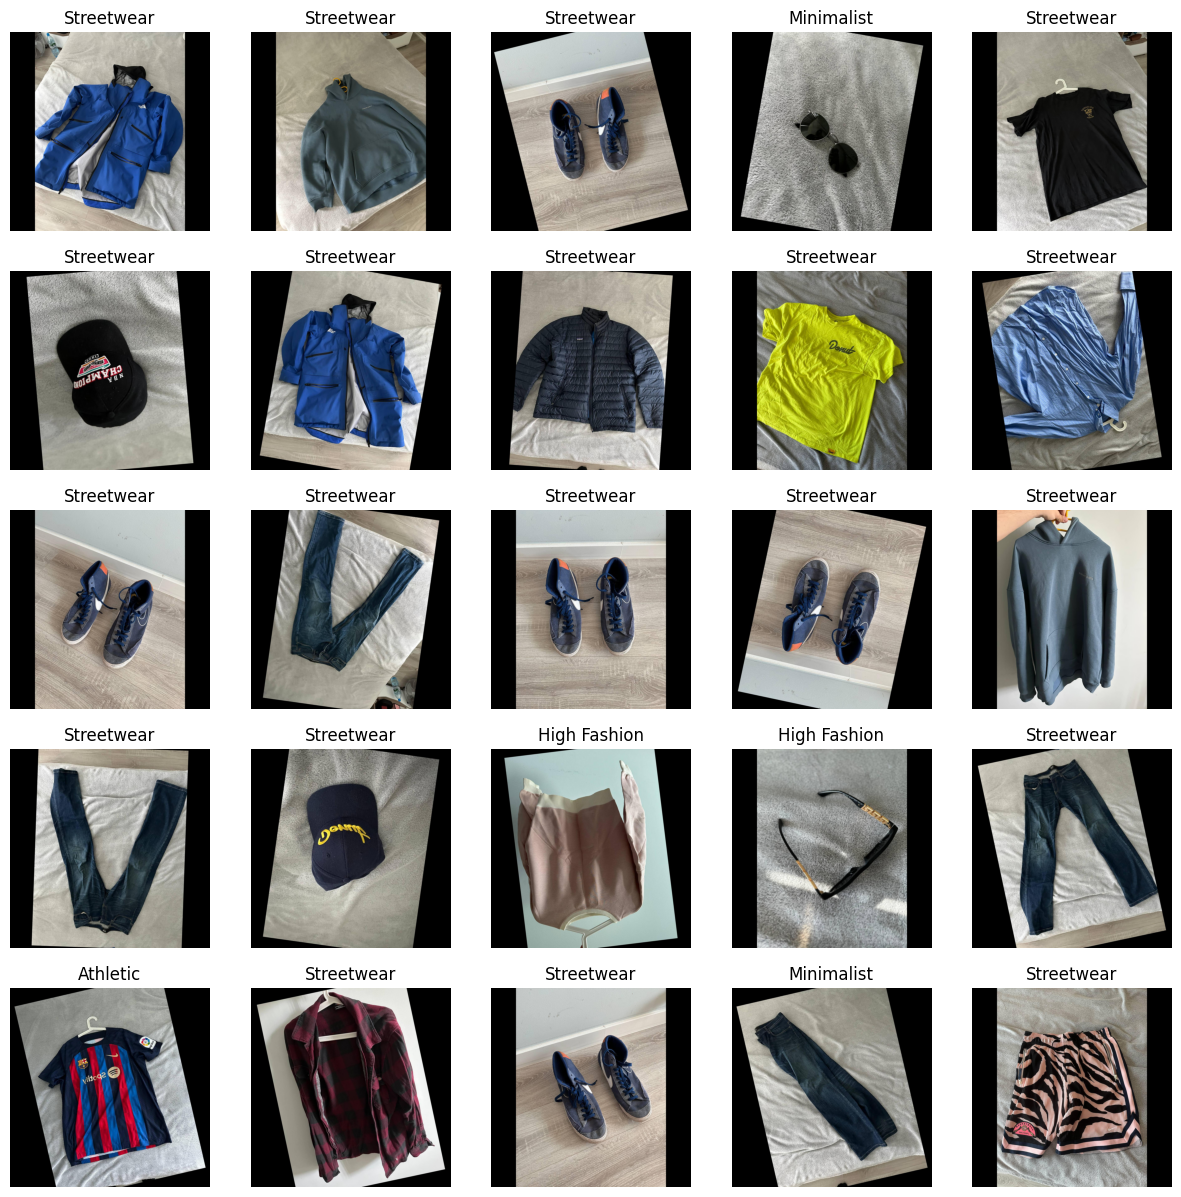

In [ ]:
images_numpy = []
predictions = []

for image_path in tqdm(image_paths):
    image_pil, image_numpy = load_image(image_path=str(image_path))
    inputs = processor(text=STYLES, images=image_pil, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    probs = np.squeeze(probs.numpy())
    sort_indices = np.argsort(probs)[::-1]
    sorted_styles = np.array(STYLES)[sort_indices]

    images_numpy.append(image_numpy)
    predictions.append(sorted_styles[0])

sv.plot_images_grid(images_numpy, grid_size=(5, 5), titles=predictions, size=(15, 15))